<a href="https://colab.research.google.com/github/akshaypt7/amazon_sales_prediction/blob/main/my_project_01_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is part 2 of the project. Here we make improvements that we have learnt from part 1 of the project.

One of the mistakes we have done in the first part was that there was data leakage. 

- **When the sales are made for each asins in a day, we are not considering the asins that were not sold that day. so the thing is we need to add ASINS even when there was no sale made for that. We can give the quantity as 0. **


How do we do this?

When we read data for each month, we see which are the unique ASINs, then these asins should be added to each days in that month, even for the days when these asins are not sold. 

one another thing to note is we can even look at working this for the enitre dataframe at once, rather than going month by month. The reason is what if for one month the product was laucnhed but on second month there was no sales, even though that product was available. this means that for all those we wont even mention the asin, but on the third month we mention it again.

But finally we have decided to add the asins based on months. Since during months if the products were out of stock it is better to not to show the asin rather than showing the sold quantities as zero

- we can change the continous and categorical variables that we have defined.

- One another mistake that we had done in part 1 was that we had only taken 679 data points as the validation set, we have used 10,500 as the train set. we should have atleast taken 3000 units as validation set.

  This was the reason we had high training error and less validation error. This makes sense why we also had high OOB_error and less validation error, as oob_error is calculated with atleast 30% data.

- Also we will sum up all the orders placed for one product in a single day. This gives a structure to the dataset, and also a format like this can be used to realtime predictions.

Next thing we learnt is we need to understand what metric we have to use.

- We can use both classification and regression. When we use both then we need to understand what has to be used as the metric. This assumption was wrong, we cannot use classification since the quanities can varry btw 0-41. We had thought of this assumpltion when we were working of the first version of the project. Now it does not apply.

- Also if we are considering accuracy or even other metrics we have to create a baseline model which predicts the majority class for all the data points.

- Learn more about metrics. We have decided to use MAE, since this goes well with inventory prediction.

- One another thing what we can note is, we should be able to change the threshold. We have to able to convert the predictions for example, from 1.4 to 2, if we are going with regression. Here we need to come up with something like np.where(). We can see what is the performance at different thresholds.

- We will be adding one more that is price for each product. We also have Invoice amount, which is the price at which the product is sold (coupons).


In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 32.8 MB/s 
     |████████████████████████████████| 60 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 49.2 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 188 kB 67.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 51 kB 340 kB/s 
Mounted at /content/gdrive


In [6]:
#hide
from fastbook import *
# from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [7]:
import pandas as pd

### Getting all the csv & excel files from the folder.

In [13]:
import os
files = os.listdir('/content/gdrive/MyDrive/my_project_01')


In [18]:
dict_files = {}
for i,file in enumerate(files):
  try:
    # dict_files[i] = pd.read_csv( '/content/drive/MyDrive/my_project_01/' +str(file),low_memory=False)
    dict_files[i] = pd.read_csv( '/content/gdrive/MyDrive/my_project_01/' +str(file),low_memory=False)
  except:
    # dict_files[i] = pd.read_excel( '/content/drive/MyDrive/my_project_01/' +str(file))
    if files[i] == '.ipynb_checkpoints':
      continue
    dict_files[i] = pd.read_excel( '/content/gdrive/MyDrive/my_project_01/' +str(file))


We have to take in Invoice Amount instead of Principal amount (since it helps to sepearate canceled and refund orders)

#### Creating Dataframes

In [19]:
df_dicts = {}

for i in range(len(dict_files)):
  df_dicts[i] = dict_files[i][['Order Date','Quantity','Asin','Invoice Amount','Item Promo Discount']]


#### Applying transformations to 1 Dataframes

**Item promo can lead to data_leakage, we might have to remove it and then get the dates in which we had coupons and ads in amazon, then use that**

In [ ]:
df_new = df_dicts[2]
df_new_1 = df_new.copy()

In [ ]:
df_new_1['date'] = df_new['Order Date'].dt.date

In [ ]:
df_new  = df_new_1.drop(['Order Date'],axis=1)

In [ ]:
df_new.head()

,Quantity,Asin,Invoice Amount,Item Promo Discount,date
0,1,B07TM3LRVB,-1135.00,0.00,2020-12-28
1,1,B07TM3LRVB,-1135.00,0.00,2020-12-25
2,1,B07TM3LRVB,-1135.00,0.00,2020-12-28
3,1,B07TM3LRVB,-1135.00,0.00,2020-12-23
4,1,B07TM3LRVB,-1135.00,0.00,2020-12-18
...,...,...,...,...,...
926,1,B07TM3LRVB,1078.25,-56.75,2021-01-31
927,1,B08332221J,1424.05,-74.95,2021-01-31
928,1,B0849NLNTQ,1599.00,0.00,2021-01-31
929,1,B07TM3LRVB,1078.25,-56.75,2021-01-31


In [ ]:
asin_list = df_new.Asin.unique()
asin_list

array(['B07TM3LRVB', 'B0849NLNTQ', 'B08332221J', 'B07MK32L49', 'B08976V1BZ', 'B0859193NJ', 'B07TJ1HDTM', 'B0858X26QM', 'B07KYFHTGF', 'B0859B5J8T', 'B0897LPBHR', 'B084JJWJ31', 'B07W1YYQ9G',
       'B07ZBCTB9N', 'B07S8NC532', 'B07YC69QKT', 'B07Z7QX6ST'], dtype=object)

In [ ]:
# Converting into datetime
df_new['date'] = pd.to_datetime(df_new['date'])

##### Removing refund and returns

In [ ]:
cond = df_new['Invoice Amount'] > 0

df_new_2  = df_new.where(cond)
df_new_2.dropna(how='all',inplace = True)

In [ ]:
df_new_2.head()


,Quantity,Asin,Invoice Amount,Item Promo Discount,date
22,1.0,B07TM3LRVB,1135.0,0.0,2020-12-31
23,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
24,1.0,B08332221J,1499.0,0.0,2021-01-01
25,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
26,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01


#### Creating the dataframe for ASINs for which no sales been made

In [ ]:
max_date = max(df_new_2['date']) 
min_date = (min(df_new_2['date']))

In [ ]:
# finding all the dates btw max and min

date_list  = pd.date_range(min_date,max_date)

In [ ]:
df_asin = pd.DataFrame(columns = ['date', 'Asin'])

In [ ]:
df_asin

,date,Asin


In [ ]:
# Creating the dataframe - ASINs , for days no sales have made
index = 0
while True:

  for date in (date_list) :
    for asin in (asin_list):
      df_asin.loc[index] = [date,asin]
      index = index + 1

  break    

FInally after hours of deliberation we have done it. We have created what we wanted, now we have details of all the asins each day. Whether in a particular day a sale has been made or not.  

Now we will do this for 1 month, and from there we will getr



**I think we can add one more column that is one is total sum of the product for each day and second is product cost. We can do that maybe in the next part, we can also use np.where condition to create a column with prices for one product for example, if quantity is 1, then price is invoice amount otherwise it is price/quanity.**


For now why we are not adding it is that i think the alogo can find its meaning of product price from this data itself, say quanity 5 and total value is 2000. 

#### Trying the Transformations on 1 month

In [ ]:
df_new = df_dicts[2]
df_new_1 = df_new.copy()

In [ ]:
df_new_1['date'] = df_new['Order Date'].dt.date

In [ ]:
df_new  = df_new_1.drop(['Order Date'],axis=1)

In [ ]:
asin_list = df_new.Asin.unique()
asin_list

array(['B07TM3LRVB', 'B0849NLNTQ', 'B08332221J', 'B07MK32L49', 'B08976V1BZ', 'B0859193NJ', 'B07TJ1HDTM', 'B0858X26QM', 'B07KYFHTGF', 'B0859B5J8T', 'B0897LPBHR', 'B084JJWJ31', 'B07W1YYQ9G',
       'B07ZBCTB9N', 'B07S8NC532', 'B07YC69QKT', 'B07Z7QX6ST'], dtype=object)

In [ ]:
df_new['date'] = pd.to_datetime(df_new['date'])

In [ ]:
# Removing refund and return
cond = df_new['Invoice Amount'] > 0

df_new_2  = df_new.where(cond)
df_new_2.dropna(how='all',inplace = True)

In [ ]:
max_date = max(df_new_2['date']) 
min_date = (min(df_new_2['date']))

In [ ]:
# finding all the dates btw max and min

date_list  = pd.date_range(min_date,max_date)

In [ ]:
df_asin = pd.DataFrame(columns = ['date', 'Asin'])

In [ ]:
# Creating the dataframe - ASINs , for days no sales have made
index = 0
while True:

  for date in (date_list) :
    for asin in (asin_list):
      df_asin.loc[index] = [date,asin]
      index = index + 1

  break    

In [ ]:
df_asin.head()

,date,Asin
0,2020-12-31,B07TM3LRVB
1,2020-12-31,B0849NLNTQ
2,2020-12-31,B08332221J
3,2020-12-31,B07MK32L49
4,2020-12-31,B08976V1BZ


In [ ]:
df_new = df_new_2

In [ ]:
# Merging the datasets, so we have the details for all Asins for each day
df_merge = df_new.merge(df_asin, how='outer', on=['date','Asin'])
df_merge

,Quantity,Asin,Invoice Amount,Item Promo Discount,date
0,1.0,B07TM3LRVB,1135.0,0.0,2020-12-31
1,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
2,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
3,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
4,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
...,...,...,...,...,...
810,NaN,B084JJWJ31,NaN,NaN,2021-01-28
811,NaN,B07KYFHTGF,NaN,NaN,2021-01-29
812,NaN,B08976V1BZ,NaN,NaN,2021-01-29
813,NaN,B08332221J,NaN,NaN,2021-01-29


In [ ]:
df_merge = df_new.merge(df_asin, how='outer', on=['date','Asin'])
df_merge

,Quantity,Asin,Invoice Amount,Item Promo Discount,date
0,1.0,B07TM3LRVB,1135.0,0.0,2020-12-31
1,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
2,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
3,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
4,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01
...,...,...,...,...,...
1101,NaN,B07W1YYQ9G,NaN,NaN,2021-01-31
1102,NaN,B07ZBCTB9N,NaN,NaN,2021-01-31
1103,NaN,B07S8NC532,NaN,NaN,2021-01-31
1104,NaN,B07YC69QKT,NaN,NaN,2021-01-31


In [ ]:
# Calculating the price for each product
df_merge['price'] = df_merge['Invoice Amount']/df_merge['Quantity']

In [ ]:
# Filling NA with 0 for quantities
df_merge['Quantity'] = df_merge['Quantity'].fillna(0)

In [ ]:
# This will be zero for missing values since the sales have not been made for missing values.
df_merge['Invoice Amount'] = df_merge['Invoice Amount'].fillna(0)

In [ ]:
# This will be zero for missing values since the sales have not been made for missing values.
df_merge['Item Promo Discount'] = df_merge['Item Promo Discount'].fillna(0)

In [ ]:
df_merge.head()

,Quantity,Asin,Invoice Amount,Item Promo Discount,date,price
0,1.0,B07TM3LRVB,1135.0,0.0,2020-12-31,1135.0
1,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01,1135.0
2,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01,1135.0
3,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01,1135.0
4,1.0,B07TM3LRVB,1135.0,0.0,2021-01-01,1135.0


In [ ]:
# Finding the mode value for prices of each product, we can use that to as the price value for each asins(NA).
df_price = df_merge.groupby('Asin')['price'].agg(lambda x: np.mean(pd.Series.mode(x))).reset_index()

In [ ]:
df = df_merge.set_index('Asin')

In [ ]:
df_price = df_price.set_index('Asin')

In [ ]:
df.update(df_price,overwrite = False, join = 'left')

In [ ]:
# df = df_merge.update(df_price, overwrite = False, join = 'left')

In [ ]:
df.reset_index(inplace = True)

In [ ]:
x = df.groupby(['date','Asin','Item Promo Discount','price']).sum()
x

Quantity  Invoice Amount
date       Asin       Item Promo Discount price                             
2020-12-31 B07KYFHTGF 0.0                 1995.000       0.0             0.0
           B07MK32L49 0.0                 149.000        0.0             0.0
           B07S8NC532 0.0                 2099.000       0.0             0.0
           B07TJ1HDTM 0.0                 1649.000       0.0             0.0
           B07TM3LRVB 0.0                 1135.000       1.0          1135.0
...                                                      ...             ...
2021-01-31 B0858X26QM 0.0                 599.000        0.0             0.0
           B0859193NJ 0.0                 599.000        0.0             0.0
           B0859B5J8T 0.0                 499.000        1.0           499.0
           B08976V1BZ 0.0                 1599.000       0.0             0.0
           B0897LPBHR 0.0                 1896.375       0.0             0.0

[618 rows x 2 columns]

In [ ]:
x.reset_index()

,date,Asin,Item Promo Discount,price,Quantity,Invoice Amount
0,2020-12-31,B07KYFHTGF,0.0,1995.000,0.0,0.0
1,2020-12-31,B07MK32L49,0.0,149.000,0.0,0.0
2,2020-12-31,B07S8NC532,0.0,2099.000,0.0,0.0
3,2020-12-31,B07TJ1HDTM,0.0,1649.000,0.0,0.0
4,2020-12-31,B07TM3LRVB,0.0,1135.000,1.0,1135.0
...,...,...,...,...,...,...
613,2021-01-31,B0858X26QM,0.0,599.000,0.0,0.0
614,2021-01-31,B0859193NJ,0.0,599.000,0.0,0.0
615,2021-01-31,B0859B5J8T,0.0,499.000,1.0,499.0
616,2021-01-31,B08976V1BZ,0.0,1599.000,0.0,0.0


In [ ]:
x.loc['2021-01-31']

Quantity  Invoice Amount
date       Asin       Item Promo Discount price                             
2021-01-31 B07KYFHTGF  0.00               1995.000       0.0            0.00
           B07MK32L49  0.00               149.000        0.0            0.00
           B07S8NC532  0.00               2099.000       0.0            0.00
           B07TJ1HDTM  0.00               1649.000       0.0            0.00
           B07TM3LRVB -56.75              1078.250       6.0         6469.50
                       0.00               1135.000      12.0        13620.00
           B07W1YYQ9G  0.00               399.000        0.0            0.00
           B07YC69QKT  0.00               1649.000       0.0            0.00
           B07Z7QX6ST  0.00               486.525        0.0            0.00
           B07ZBCTB9N  0.00               1135.000       0.0            0.00
           B08332221J -74.95              1424.050       1.0         1424.05
           B0849NLNTQ  0.00               1599.000       2.0         3198.00
           B084JJWJ31  0.00               599.000        0.0            0.00
           B0858X26QM  0.00               599.000        0.0            0.00
           B0859193NJ  0.00               599.000        0.0            0.00
           B0859B5J8T  0.00               499.000        1.0          499.00
           B08976V1BZ  0.00               1599.000       0.0            0.00
           B0897LPBHR  0.00               1896.375       0.0            0.00

### Working with all the dataframes

In [ ]:
# concat all df
def process_data(df_dicts):

  df_main = pd.DataFrame()


  for i in range(len(df_dicts)):
  # we need to convert the Order date column into date_time
  # if df_dicts[i]['Order Date'].dtype != 'datetime64[ns]' :
    df_copy = df_dicts[i].copy()

    df_copy['Order Date'] = pd.to_datetime(df_dicts[i]['Order Date'])

    # adding new columns
    df_copy['date'] = df_copy['Order Date'].dt.date #
    df_copy['hour'] = df_copy['Order Date'].dt.hour

    df_dicts[i] = df_copy.drop(['Order Date'],axis=1) 

    # Creating dataframe for all unique asins in one month
    asin_list = df_dicts[i].Asin.unique()

    # Removing refund and return
    cond = df_dicts[i]['Invoice Amount'] > 0

    df_copy_2  = df_dicts[i].where(cond)
    df_copy_2.dropna(how='all',inplace = True) # Removing all transactions that are either refund or return

    max_date = max(df_copy_2['date']) 
    min_date = (min(df_copy_2['date']))
    date_list  = pd.date_range(min_date,max_date)


    # Creating Asin Dataframe
    df_asin = pd.DataFrame(columns = ['date', 'Asin'])
    index = 0
    while True:

        for date in (date_list) :
          for asin in (asin_list):
            df_asin.loc[index] = [date,asin]
            ndex = index + 1

        break    
    df_copy_2['date'] = pd.to_datetime(df_copy_2['date'])  

    df_dicts[i] = df_copy_2


    # Merging the dataframes
    df_merge = df_copy_2.merge(df_asin, how='outer', on=['date','Asin'])
    
    # Creating new columns
    df_merge['price'] = df_merge['Invoice Amount']/df_merge['Quantity']
    df_merge['Quantity'] = df_merge['Quantity'].fillna(0)
    df_merge['Invoice Amount'] = df_merge['Invoice Amount'].fillna(0)
    df_merge['Item Promo Discount'] = df_merge['Item Promo Discount'].fillna(0)

    # Filling missing values in df_price
    df_price = df_merge.groupby('Asin')['price'].agg(lambda x: np.mean(pd.Series.mode(x))).reset_index()

    df = df_merge.set_index('Asin')
    df_price = df_price.set_index('Asin')

    df.update(df_price,overwrite = False, join = 'left')

    df = df.groupby(['date','Asin','Item Promo Discount','price']).sum()
    df.reset_index(inplace=True)

    df_main = pd.concat([df_main , df])

  
  return df_main    


In [ ]:
df_main = process_data(df_dicts)


In [ ]:
# save_pickle('/content/gdrive/MyDrive/my_project_01/df_main.pkl',df_main)

In [ ]:
df_main.shape

(4726, 7)

### Setting up train and validation data

In [ ]:
df_main = add_datepart(df_main , 'date')

In [ ]:
# save_pickle('/content/gdrive/MyDrive/my_project_01/df_main.pkl',df_main)

In [ ]:
df_main.columns

Index(['Asin', 'Item Promo Discount', 'price', 'Quantity', 'Invoice Amount',
       'hour', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
dep_var = 'Quantity'

In [ ]:
cont, cat = cont_cat_split( df_main,1,dep_var= dep_var)

In [ ]:
# SPLITS 
condition = (df_main.Year < 2020) | (df_main.Month < 6)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

In [ ]:
len(train_idx), len(valid_idx)

(2531, 2195)

In [ ]:
splits = (list(train_idx),list(valid_idx))

In [ ]:
to = TabularPandas(df_main, procs= procs,cat_names= cat, cont_names=cont, splits= splits,y_names=dep_var)

In [ ]:
to.show(3)

,Asin,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Item Promo Discount,price,Invoice Amount,hour,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,Quantity
0,B07KYFHTGF,False,False,False,False,False,False,0.000000,1995.000000,1995.000000,12.0,2021,1,1,4,0,4,1.609718e+09,1.0
1,B07TM3LRVB,False,False,False,False,False,False,-56.750000,1078.250000,1078.250000,20.0,2021,1,1,8,4,8,1.610064e+09,1.0
2,B08976V1BZ,False,False,False,False,False,False,-79.949997,1519.050049,1519.050049,22.0,2021,1,1,9,5,9,1.610150e+09,1.0


In [ ]:
x_train,y_train = to.train.xs, to.train.y
x_valid, y_valid = to.valid.xs, to.valid.y

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=2000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
rf =rf(x_train,y_train)

In [ ]:

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(rf,x_train,y_train), m_rmse(rf,x_valid,y_valid)

(0.570982, 0.609243)

In [ ]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3708, 18), (3708,), (1018, 18), (1018, 18))

In [ ]:
y_valid.head()

,Asin,Is_month_end,Is_month_start,Is_quarter_end,...,Day,Dayofweek,Dayofyear,Elapsed
0,8,2,1,2,...,31,3,366,1.609373e+09
194,2,1,1,1,...,2,3,245,1.630541e+09
195,2,1,1,1,...,2,3,245,1.630541e+09
196,2,1,1,1,...,2,3,245,1.630541e+09
197,8,1,1,1,...,2,3,245,1.630541e+09


We need to think about someother metric to use other than this, which is more accurate to the problem at hand. 

In [ ]:
a = rf.predict(x_valid)[0:50]
a

array([0.96215278, 1.009375  , 1.009375  , 1.        , 2.97310974, 1.00416667, 4.94278028, 0.994375  , 0.994375  , 2.83370942, 1.04414773, 0.994375  , 0.994375  , 2.0851076 , 1.        , 3.49416396,
       4.24072851, 6.0205797 , 1.004375  , 0.994375  , 1.9875    , 3.87659407, 1.01598214, 2.44454761, 3.50460312, 0.994375  , 1.014375  , 1.004375  , 1.        , 6.37903364, 9.01998662, 0.994375  ,
       2.0125    , 1.01241071, 1.02758929, 1.81420635, 2.00833333, 1.009375  , 1.009375  , 1.00416667, 1.00416667, 2.94821886, 1.016875  , 2.021875  , 1.01508929, 1.01241071, 1.93393849, 1.004375  ,
       1.2335092 , 1.009375  ])

In [ ]:
b = np.round(rf.predict(x_valid)[0:50])
b

array([1., 1., 1., 1., 3., 1., 5., 1., 1., 3., 1., 1., 1., 2., 1., 3., 4., 6., 1., 1., 2., 4., 1., 2., 4., 1., 1., 1., 1., 6., 9., 1., 2., 1., 1., 2., 2., 1., 1., 1., 1., 3., 1., 2., 1., 1., 2., 1.,
       1., 1.])

In [ ]:
c = y_valid[0:50].values
c

array([ 1.,  1.,  1.,  1.,  3.,  1.,  5.,  1.,  1.,  3.,  1.,  1.,  1.,  2.,  1.,  3.,  4.,  6.,  1.,  1.,  2.,  4.,  1.,  2.,  4.,  1.,  1.,  1.,  1.,  6., 10.,  1.,  2.,  1.,  1.,  2.,  2.,  1.,
        1.,  1.,  1.,  3.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  1.], dtype=float32)

In [ ]:

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(np.round(m.predict(xs)), y)

In [ ]:
m_rmse(rf,x_train,y_train), m_rmse(rf,x_valid,y_valid)

(0.582912, 0.637835)

What actually I can think of is we can create a custom accuracy function.

##### Using Mean Absolute Percentage Error

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
MAPE(y_valid,np.round(rf.predict(x_valid))) # We cannot use MAPE because we have zero. y_actuals have 0 variables.

inf

In [ ]:
MAPE(c,a)

3.1955525814735397

In [ ]:
MAPE(c,b)

0.2

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
mae(y_valid,rf.predict(x_valid))

0.2383354743952306

In [ ]:
mae(y_valid,np.round(rf.predict(x_valid)))

0.20182232346241458

In [ ]:
mae(y_train,np.round(rf.predict(x_train)))

0.07822994863690241

In [ ]:
mae(y_train,rf.predict(x_train))

0.12547872534779161

Creating our own accuracy metric

In [ ]:
int(1.6)

1

In [ ]:
def pred(y_pred,thres= 0.5):
  new_pred = np.where((y_pred-int(y_pred)) < thres,int(y_pred), int(y_pred)+1)
  return new_pred

In [ ]:
new_pred = np.vectorize(pred)

In [ ]:
mae(y_train,new_pred(rf.predict(x_train)),0.8)

TypeError: ignored

In [ ]:
mae(y_valid,(new_pred(rf.predict(x_valid),0.42)))


0.18952164009111616

In [ ]:
mae(y_valid,(new_pred(rf.predict(x_valid),0.5)))

0.20182232346241458

What else we can do now, we can look at the.\

we have to create a baseline model

In [ ]:
y_valid.value_counts()

1.0     977
2.0     409
3.0     229
4.0     150
5.0      84
       ... 
19.0      4
18.0      4
20.0      3
23.0      2
26.0      1
Name: Quantity, Length: 23, dtype: int64

In [ ]:

base_y = [1]*len(y_valid)

In [ ]:
mae(y_valid,base_y)

2.0929384965831437

In [ ]:
preds = np.stack([t.predict(x_valid) for t in rf.estimators_])

In [ ]:
mae(new_pred(preds.mean(0),0.42), y_valid)

0.18952164009111616

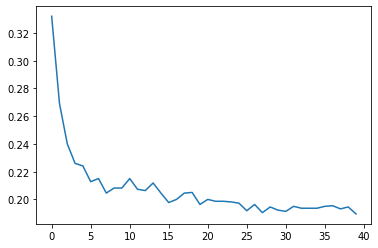

In [ ]:
plt.plot([mae(new_pred(preds[:i+1].mean(0),0.42), y_valid) for i in range(40)]);

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(rf, x_train)
fi[:10]

,cols,imp
10,hour,0.613383
9,Invoice Amount,0.331503
0,Asin,0.025408
8,price,0.016958
17,Elapsed,0.003857
16,Dayofyear,0.002096
15,Dayofweek,0.002057
13,Week,0.001265
14,Day,0.001249
12,Month,0.000923


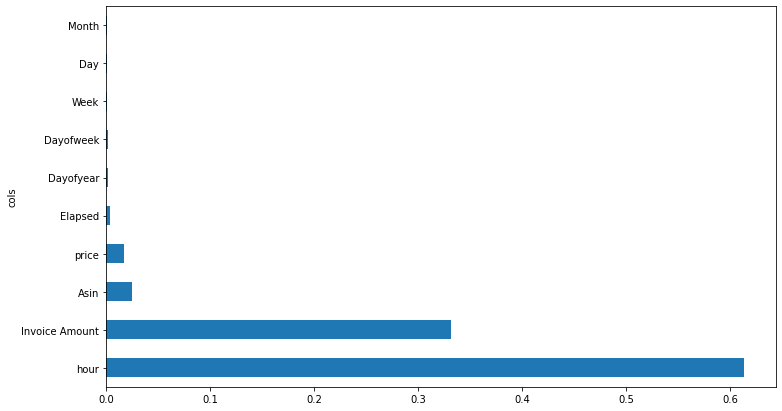

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10]);

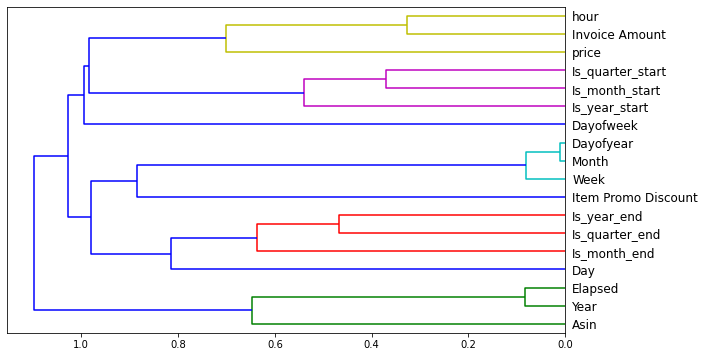

In [ ]:
cluster_columns(x_train)

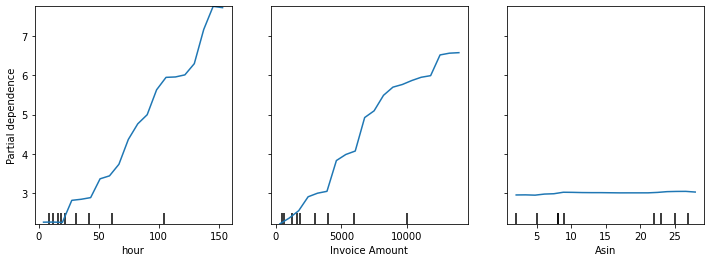

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(rf, x_valid, ['hour','Invoice Amount','Asin'],
                        grid_resolution=20, ax=ax);

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
row = x_valid.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(rf, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([0.96215278]), 2.5407249999999997, -1.5785722222222223)

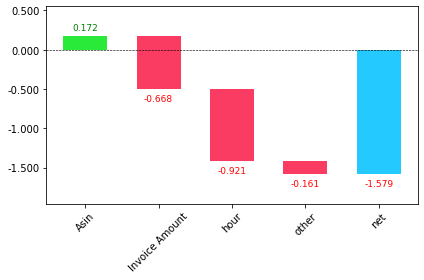

In [ ]:
waterfall(x_valid.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [ ]:
df_main.columns

Index(['Asin', 'Item Promo Discount', 'price', 'Quantity', 'Invoice Amount',
       'hour', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_main, max_card=9000, dep_var=dep_var)

In [ ]:
df_main[cat_nn].nunique()

Asin                 46
Year                  3
Month                12
Week                 53
Day                  31
Dayofweek             7
Dayofyear           366
Is_month_end          2
Is_month_start        2
Is_quarter_end        2
Is_quarter_start      2
Is_year_end           2
Is_year_start         2
dtype: int64

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_main, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(528)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

(0.0, 41.0)

In [ ]:
learn = tabular_learner(dls, y_range=(0,42), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0020892962347716093)

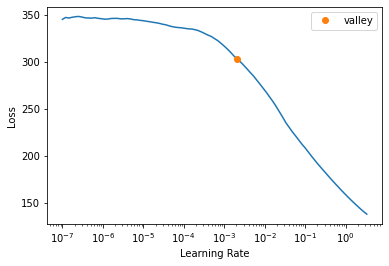

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,335.170654,310.284088,00:00
1,311.091248,309.897705,00:00
2,278.202393,323.489899,00:00
3,255.876755,348.911682,00:00
4,239.897247,377.139771,00:00


In [ ]:
preds,targs = learn.get_preds()
mae(new_pred(preds,0.42),targs)

19.189521640091115